In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
     return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(ys)

[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


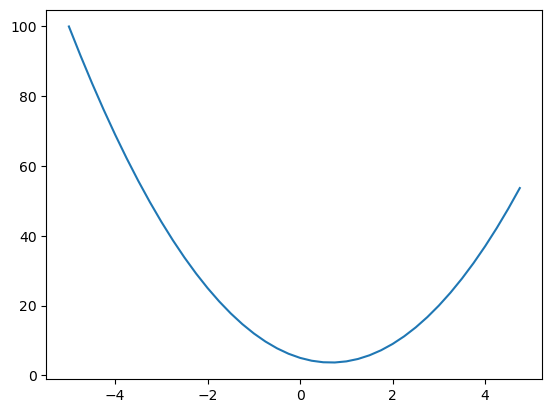

In [5]:
plt.plot(xs, ys)

In [6]:
# up/down and how much -> strenght slop
# F decreases -> slop negative 
h = 0.0000000001
x = 2/3 # -3 
print(f(x))
print(f(x+h))
print((f(x + h) - f(x))/h)

3.666666666666667
3.666666666666667
0.0


In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

#a += h
#b += h
c += h # By the amount we added. Slope is one
d2 = a*b + c

print('d1',d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [69]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # For a + a do not overwrite 
            other.grad += 1.0 * out.grad
            
        out._backward = _backward 
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward 
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other 
      
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "give int/float for powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other *(self.data**(other -1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - (t**2)) * out.grad
            
        out._backward = _backward
        
        return out

    def backward(self):       
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Add list while all children visited 

        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

    # a.__add__(b)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
#print(a)
#d = a * b + c
#print(d._prev)
#print(d._op)
e = a * b
e.label = 'e'
d = e + c
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
print(d)
print(L)

Value(data=4.0)
Value(data=-8.0)


In [11]:
import graphviz
from graphviz import Digraph

def trace(root):
    # Enumerte #
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left-right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot 

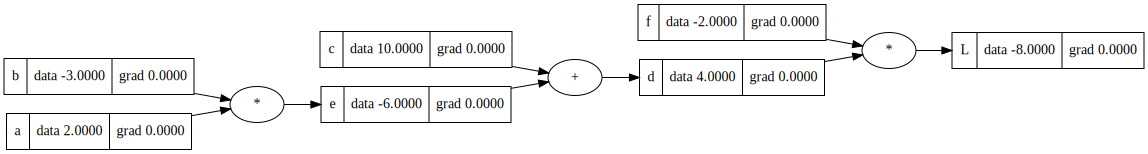

In [12]:
draw_dot(L)

In [13]:
# L/DL -> 1 
L.grad = 1.0
#L = d * f 
#dl/dd  = ? -> f
f.grad = 4.0
d.grad = -2.0 
# dd/dc = 1.0
# dd/de = 1.0 -> local 
# dL/dc = dL/dd * dd/dc
c.grad = 1.0 * d.grad 
e.grad = 1.0 * d.grad 
a.grad = b.data * e.grad
b.grad = a.data * e.grad


a.data += 0.01 * a.grad
c.data += 0.01 * a.grad
d.data += 0.01 * a.grad
e.data += 0.01 * a.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.760000000000002


In [14]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data# -> h 1 base case
  
  print((L2 - L1)/h)
  
lol()

0.0


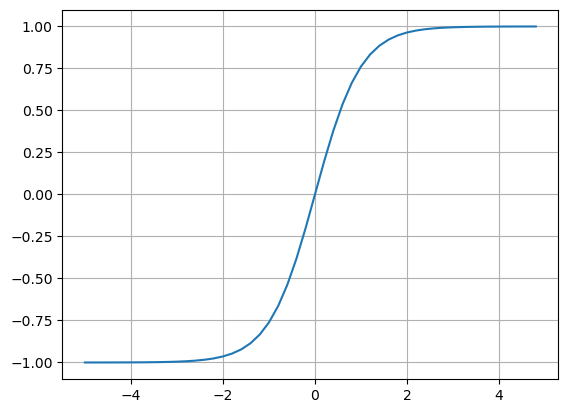

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()


In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2;'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


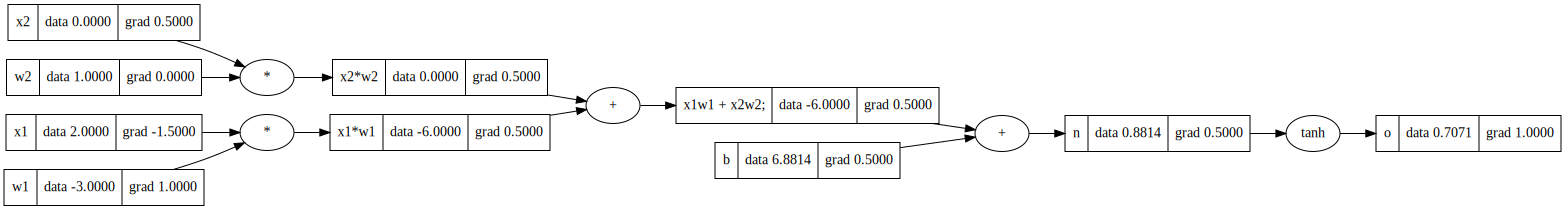

In [32]:
draw_dot(o)

In [18]:
"""o.grad = 1.0
n.grad = (1 - (o.data**2))
x1w1x2w2.grad = 1.0 * n.grad 
b.grad = 1.0 * n.grad 
x1w1.grad = 1.0 * x1w1x2w2.grad
x2w2.grad = 1.0 * x1w1x2w2.grad
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad""" 

'o.grad = 1.0\nn.grad = (1 - (o.data**2))\nx1w1x2w2.grad = 1.0 * n.grad \nb.grad = 1.0 * n.grad \nx1w1.grad = 1.0 * x1w1x2w2.grad\nx2w2.grad = 1.0 * x1w1x2w2.grad\nw2.grad = x2.data * x2w2.grad\nw1.grad = x1.data * x1w1.grad\nx2.grad = w2.data * x2w2.grad\nx1.grad = w1.data * x1w1.grad'

In [19]:
o.grad = 1.0
o._backward()
n._backward()

In [20]:
b._backward() # Leaf -> nothing 
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [26]:
"""o.grad = 1.0
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Add list while all children visited 
    
build_topo(o)
topo 

for node in reversed(topo):
    node._backward()"""

In [31]:
o.backward()

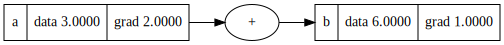

In [35]:
a = Value(3.0, label="a")
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

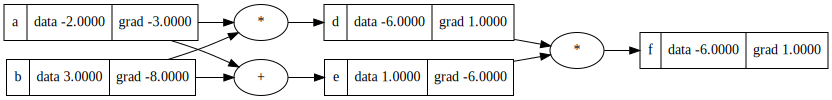

In [36]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [70]:
a = Value(2.0)
a + 1 # a.__add_(2)
1 + a # ops 
2 * a

Value(data=4.0)

In [71]:
a.exp()

Value(data=7.38905609893065)

In [72]:
b = Value(4.0)
a / b 

Value(data=0.5)

In [73]:
a - b

Value(data=-2.0)

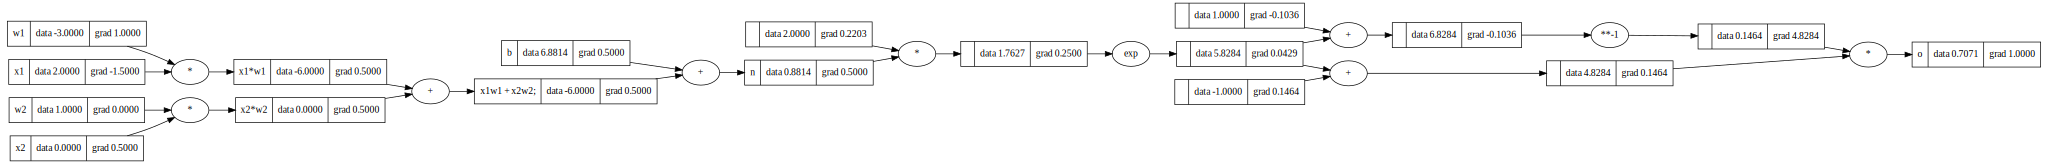

In [74]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2;'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [78]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True 
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358
-1.5000003851533106
0.5000001283844369
tensor([0.7071], dtype=torch.float64)
1.0000002567688737
0.0


In [237]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #    return params 
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # List concat 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
      
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
#x = [2.0, 3.0]
#n = Neuron(2)
#n = Layer(2, 3)
#n(x)

In [245]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
print([5] + [1, 2, 3])

[5, 1, 2, 3]


In [246]:
#draw_dot(n(x))
n.parameters()
print(len(n.parameters()))

41


In [247]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

#ypred = [n(x) for x in xs]
#ypred 

In [229]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.177729164314508)

In [230]:
#loss.backward()
n.layers[0].neurons[0].w[0].grad

0.0

In [231]:
#draw_dot(loss)
loss.backward()
n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

-0.479891802707495

In [232]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [233]:
n.layers[0].neurons[0].w[0].grad
n.layers[0].neurons[0].w[0].data

-0.4853585426813167

In [234]:
ypred = [n(x) for x in xs]
ypred 
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.12629292571405545)

In [235]:
print(ypred)

[Value(data=0.8239775475047248), Value(data=-0.8370917401603697), Value(data=-0.8418540666732666), Value(data=0.790811605054573)]


In [236]:
n.parameters()

[Value(data=-0.4853585426813167),
 Value(data=-0.9001835568599814),
 Value(data=-0.6733439066912599),
 Value(data=-0.8474585842965385),
 Value(data=0.25652199504048284),
 Value(data=-0.06296631981644336),
 Value(data=-0.6698323951100879),
 Value(data=0.7802555499486469),
 Value(data=0.3856909295743),
 Value(data=0.24448609730339907),
 Value(data=-0.899117326321881),
 Value(data=-0.3538147107735867),
 Value(data=-0.5352473824192454),
 Value(data=0.20511377590170132),
 Value(data=-0.9316424806750105),
 Value(data=0.5084386928481158),
 Value(data=0.21356449378575248),
 Value(data=0.907473854669284),
 Value(data=-1.0101569254379883),
 Value(data=-0.41098214950140377),
 Value(data=0.5501514823837163),
 Value(data=0.9708914990767837),
 Value(data=0.09979044945508435),
 Value(data=0.5285237005176859),
 Value(data=0.8625272800967962),
 Value(data=-0.7257564528482178),
 Value(data=0.44972946709706824),
 Value(data=0.31198709901812977),
 Value(data=-0.7108186331676908),
 Value(data=-0.8121141823

In [254]:
for k in range(20):
    
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0
        
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0067069116401506975
1 0.0066404351375091205
2 0.006575187551234784
3 0.006511135956840819
4 0.006448248579050107
5 0.0063864947425488
6 0.0063258448252339235
7 0.006266270213810153
8 0.006207743261599542
9 0.006150237248437223
10 0.006093726342534488
11 0.006038185564198191
12 0.005983590751302011
13 0.005929918526412602
14 0.005877146265478993
15 0.005825252067999836
16 0.0057742147285877055
17 0.005724013709855934
18 0.005674629116556027
19 0.005626041670900032


In [244]:
print(ypred)

[Value(data=0.9999997888833876), Value(data=-0.9999999982722887), Value(data=-0.9999999991753419), Value(data=0.9999997883845202)]
